In [1]:
from matplotlib import pyplot as plt
from pandas.tools.plotting import table
import subprocess
%matplotlib inline
import re
from functools import reduce
from tqdm import tqdm
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
from scipy import interp
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import subprocess
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import re
import seaborn as sns
from functools import reduce
from sklearn.model_selection import LeaveOneOut
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils.multiclass import unique_labels

## miRNA

In [2]:
dset_res=pd.read_csv("clintab_GMQL/miRNA/res_miRNA/res_miRNA_new.csv", delimiter='\t')
dset_senl=pd.read_csv("clintab_GMQL/miRNA/sl_miRNA_32/sl_miRNA_new.csv", delimiter='\t')
dset_sens=pd.read_csv("clintab_GMQL/miRNA/ss_miRNA_32/ss_miRNA_new.csv", delimiter='\t')

In [3]:
dset_sens.head(1)

,patient,chrom,start,stop,mirna_id,rpm,entrez_id,gene_symbol
0,SS_00000,chr1,17368,17436,hsa-mir-6859-1,0.0,102466751.0,mir6859-1


In [37]:
resdf=dset_res.pivot(index="patient", columns="mirna_id", values="rpm")
genes = resdf.columns.tolist()
resdf.shape

(60, 1881)

In [38]:
senldf=dset_senl.pivot(index="patient", columns="mirna_id", values="rpm")
senldf = senldf[genes]
senldf.shape

(34, 1881)

In [39]:
sensdf=dset_sens.pivot(index="patient", columns="mirna_id", values="rpm")
sensdf = sensdf[genes]
#sensdf.shape

In [27]:
resdf_median = resdf.median(0)
senldf_median = senldf.median(0)
sensdf_median = sensdf.median(0)

In [40]:
sendf=pd.concat([senldf, sensdf])

In [41]:
resdf_median = resdf.median(0)
sendf_median = sendf.median(0)

In [42]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(sendf[gene],resdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
    pvalues.append(gene_pvalue)
       
pvalues = pd.DataFrame({
    "gene": genes,
    "resistant_median": resdf_median.values,
    "sensitive_median": sendf_median.values,
    #"sensitive_long_median": senldf_median.values,
    #"sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})

pvalues.head()

100%|██████████| 1881/1881 [00:00<00:00, 2210.76it/s]


,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
0,hsa-let-7a-1,27561.568283,26248.703835,0.353845
1,hsa-let-7a-2,27410.011099,26414.926234,0.352860
2,hsa-let-7a-3,27712.277110,26681.019764,0.344041
3,hsa-let-7b,76156.849794,76479.938310,0.404210
4,hsa-let-7c,16569.844066,15237.692920,0.387874


## Selection from p_value

In [43]:
threshold = 0.005

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

11


In [44]:
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()
#significant_genes.to_csv('new_data/miRNA/r_sl_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/miRNA/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/miRNA/sl_ss_pv2.csv', sep=',', header=True, index=False)

,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
780,hsa-mir-4435-1,0.000000,0.000000,0.000445
935,hsa-mir-4657,0.000000,0.270908,0.000631
450,hsa-mir-3187,1.886761,3.124205,0.000656
1528,hsa-mir-6715a,0.000000,0.558656,0.001328
605,hsa-mir-378d-2,0.000000,0.383233,0.001593


In [ ]:
lista=list(significant_genes['gene'])
type(lista)

In [ ]:
dset_sens.head()

In [ ]:
x = dset_sens[dset_sens.mirna_id.isin(lista)]
y=pd.DataFrame(x)
y.head(18)
y.to_csv('new_data/miRNA/Stot_R_last.csv', sep=',', header=True, index=False)

In [45]:
column=significant_genes['gene']
column.head()

780     hsa-mir-4435-1
935       hsa-mir-4657
450       hsa-mir-3187
1528     hsa-mir-6715a
605     hsa-mir-378d-2
Name: gene, dtype: object

In [ ]:
lista=column.values
np.save("miRNA_stot_vs_res.npy", lista)

## Bonferroni, len(p_values)

In [ ]:
p_value_corr =[]

for index, value in tqdm(pvalues['gene'].iteritems()): 
        
        somma=len(pvalues)
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value_corr)
print(len(p_value_corr))

In [ ]:
pvalues=pd.DataFrame(pvalues)

In [ ]:
pvalues['p_value_corr']=p_value_corr
#pvalues.head()

In [ ]:
threshold = 0.05

significant_genes_corr = pvalues[(pvalues.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

In [ ]:
column=significant_genes_corr['gene']
column.head()

## Bonferroni, len(patients)

In [ ]:
threshold = 0.5

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

In [ ]:
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()

In [ ]:
n_res=len(dset_res['patient'].unique())
n_sens=len(dset_sens['patient'].unique())
n_senl=len(dset_senl['patient'].unique())
n_sen=n_sens+n_senl

In [ ]:
p_value_corr =[]

for index, value in tqdm(significant_genes['gene'].iteritems()): 
        
        somma=n_sen+n_res
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value_corr)
print(len(p_value_corr))

In [ ]:
significant_genes['p_value_corr']=p_value_corr

In [ ]:
threshold = 0.05

significant_genes_corr = significant_genes[(significant_genes.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

In [ ]:
#significant_genes.to_csv('new_data/gene_exprs/r_sl_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/sl_ss_pv2.csv', sep=',', header=True, index=False)

In [ ]:
column=significant_genes_corr['gene']
column.head()

## FDR 

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
pvalues_FDR=pvalues['mannwhiteney_pvalue']
p_corrected=fdrcorrection(pvalues_FDR, alpha=0.05, method='indep')
w=p_corrected[1]

p_sorted['p_value_corr_bh']=w
p_sorted.head()

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
significant_genes_bh=pd.DataFrame(significant_genes_bh)
print(significant_genes_bh.shape[0])

In [ ]:
column=significant_genes_bh['gene']
column.head()

## Benjamini-Hochberg, len(patients)

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
a=p_sorted['mannwhiteney_pvalue'].get_values()

In [ ]:
enumerate(a)

In [ ]:
num_total_tests=n_res+n_sen #inserisci il num pazienti

In [ ]:
def calc_benjamini_hochberg_corrections(p_values, num_total_tests):
   
    p_value_bh = []
    for i, p_value in enumerate(p_values):
        bh_value = p_value * num_total_tests / (i + 1)
        p_value_bh.append(bh_value)
    return (p_value_bh)

In [ ]:
p_value_corr_bh=calc_benjamini_hochberg_corrections(a, num_total_tests)

In [ ]:
p_sorted['p_value_corr_bh']=p_value_corr_bh

In [ ]:
p_sorted.head()

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
print(significant_genes_bh.shape[0])

In [ ]:
significant_genes_bh=pd.DataFrame(significant_genes_bh)
significant_genes_bh.head()

In [ ]:
#significant_genes_bh.to_csv('new_data/gene_exprs/sl_ss_bh_ge.csv', sep=',', header=True, index=False)

In [ ]:
column=significant_genes_bh['gene']
column.head()

## Classification

In [46]:
res_selected=resdf[column]
res_selected["label"]=1
res_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(60, 12)

In [23]:
senl_selected=senldf[column]
senl_selected["label"]=0
senl_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(34, 22)

In [33]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(107, 13)

In [47]:
sen_selected=sendf[column]
sen_selected["label"]=0
sen_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(141, 12)

In [48]:
#concatenated=pd.concat([res_selected, senl_selected])
#concatenated=pd.concat([res_selected, sens_selected])
#concatenated=pd.concat([senl_selected, sens_selected])
concatenated=pd.concat([res_selected, sen_selected])

In [49]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [ ]:
#kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_res', 'false_senl', 'true_senl', 'false_res', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    print (i)
    i=i+1

In [ ]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Average f1_score: ', np.mean(fscore))
print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))
print('Standard_deviation f1_score: ', np.std(fscore))

In [ ]:
performance

## Data visualization

In [ ]:
def my_PCA(data, features, labels, i, j):
    #x = data.loc[:, features].values
    x = StandardScaler().fit_transform(data)
    
    pca= PCA(n_components=3)
    p_comp=pca.fit_transform(x)
    #p_comp = TSNE(n_components=2, perplexity=70, n_iter=2500).fit_transform(x)
    p_comp=p_comp[:, [i,j]]

    principalDf = pd.DataFrame(data = p_comp
             , columns = ['principal component '+str(i), 'principal component '+str(j)])
    finalDf= pd.concat([principalDf, pd.Series(labels)], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(i+1), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(j+1), fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    



    targets = ['Sensitive_long', 'Sensitive_short']
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        t=0
        if target == 'Sensitive_short':
            t=1
        #if target == 'Sensitive_long':
         #   t=2
        indicesToKeep = finalDf[0] == t
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(i)]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(j)]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [ ]:
my_PCA(X, concatenated.columns, y, 0, 2)
#plt.savefig('my_PCA_res_sens_12.png')
my_PCA

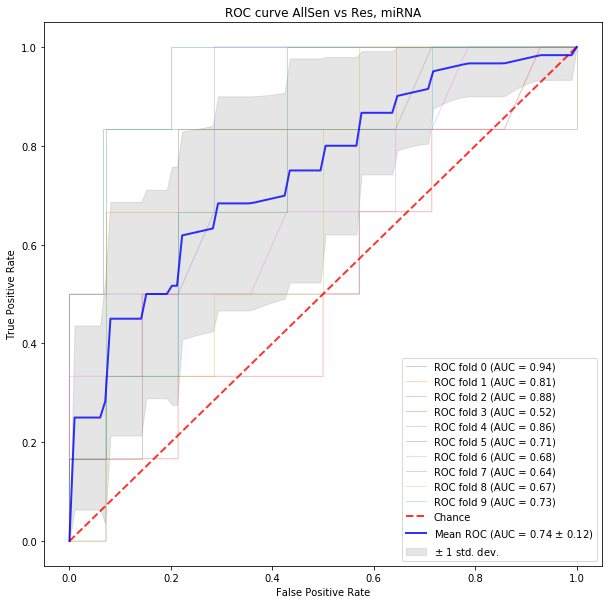

In [50]:
# ROC curve
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#classifier = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
#classifier = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#classifier=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#classifier= LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve AllSen vs Res, miRNA')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
 #         fancybox=True, shadow=True, ncol=5)
plt.legend(loc='lower right')
plt.savefig('2.png')

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
y_real = []
y_proba = []
#predictor= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
predictor = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#predictor = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#predictor = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve Res vs Senl')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('ROC_Res_vs_SenS.png')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thr = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
#plt.show()
#plt.title('PR curve Res vs SenS')
#plt.savefig('PR curve Res vs Senl_RF.png')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix